In [2]:

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
class State(TypedDict):     #type hint

 messages: Annotated[list, add_messages]

In [5]:
@tool                                          #docstring useful for llm ,In real life we can use
                                              #Some finance Api

def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)               #0 is like fallback if the stock symbol is not there

tools = [get_stock_price]

In [6]:
import os

In [7]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    api_key=os.getenv("GROQ_API_KEY")
)

In [8]:
llm_with_tools = llm.bind_tools(tools) # binding my tool with llm

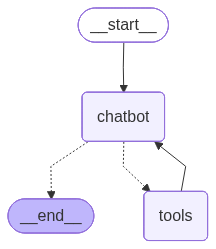

In [18]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)                #graph with state

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)# it will either go to tools or end


builder.add_edge("tools", "chatbot")                                      # so no  need of end edge
# Now another edge back from tools to chatbot is created

graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)  # its going to tool as its a relevant message that needs tool acess

The current price of Apple (AAPL) stock is **$100.40**.


In [11]:

state = graph.invoke({"messages": [{"role": "user", "content": "Who created NATO"}]})
print(state["messages"][-1].content)  # No need of tool access when other question is asked
                                      # that does not require tool acess




The North Atlantic Treaty Organization (NATO) was created in the aftermath of World II as a collective‑defence alliance among the United States, Canada and a group of Western European nations.  

**Key points about its creation**

| Item | Details |
|------|---------|
| **Founding date** | **4 April 1949** – the North Atlantic Treaty (the “Treaty of Washington”) was signed in Washington, D.C. |
| **Founding members** | 12 original signatories: **Belgium, Canada, Denmark, France, Iceland, Italy, Luxembourg, the Netherlands, Norway, Portugal, the United Kingdom, and the United States**. |
| **Primary architect** | The idea was championed by **U.S. Secretary of State George C. Marshall** (who also launched the Marshall Plan) and other senior U.S. officials, who saw a trans‑Atlantic security pact as a way to contain Soviet expansion and provide mutual defense for Western democracies. |
| **Purpose** | Article 5 of the treaty commits each member to consider an armed attack against one as an

In [ ]:
#### Now let me  add context and make it agentic

In [12]:
state = graph.invoke({"messages": [{"role": "user", "content":"I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?" }]})
print(state["messages"][-1].content)

#Its reasoning and its now agentic with multi turn approach as a new edge has been added back from tool to chatbot along

#with the conditional edge

Here’s the cost breakdown based on the current prices:

| Stock | Price per share | Quantity | Sub‑total |
|-------|----------------|----------|-----------|
| AMZN  | $150.00        | 20       | $3,000.00 |
| MSFT  | $200.30        | 15       | $3,004.50 |

**Total cost:** **$6,004.50**.


In [ ]:
# NOW Lets add memory or context

In [16]:
state = graph.invoke({"messages": [{"role": "user", "content":"using the previous total of 20 amazon and 15 microsoft stock add 15 ril stock and tell me the total cost now" }]})
print(state["messages"][-1].content)

Here’s the breakdown:

| Stock | Quantity | Price per share | Cost |
|-------|----------|----------------|------|
| Amazon (AMZN) | 20 | $150.00 | **$3,000.00** |
| Microsoft (MSFT) | 15 | $200.30 | **$3,004.50** |
| Reliance (RIL) | 15 | $87.60 | **$1,314.00** |
| **Total** | — | — | **$7,318.50** |

So, after adding the 15 RIL shares, the total cost of all your holdings is **$7,318.50**.


In [ ]:
#An important think to node its able to recall but its because of appending reducer function.

#We will use memory function of langGraph by thread id

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


#checkpointer added during compilation

In [19]:
config1 = { 'configurable': { 'thread_id': '1'} }  # thread id is 1

msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The total cost would be:

- **20 AMZN shares** at **$150.00** each → **$3,000.00**  
- **15 MSFT shares** at **$200.30** each → **$3,004.50**

**Overall total:** **$6,004.50**.


In [20]:
config2 = { 'configurable': { 'thread_id': '2'} }  #thread id is 2

msg = "Tell me the current price of 5 AAPL stocks."

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price for Apple (AAPL) is **$100.40** per share.  

So, 5 shares would cost:

**5 × $100.40 = $502.00**.


In [21]:
msg = "Using the current price tell me the total price of 10 RIL stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)   # its adding this to thread 1 and not 2


# so two different context

- **10 RIL shares** at **$87.60** each → **$876.00**  

Adding this to the earlier total of **$6,004.50** gives:

**$6,004.50 + $876.00 = $6,880.50**  

So the combined cost for all the shares you mentioned is **$6,880.50**.


In [22]:
msg = "Tell me the current price of 5 MSFT stocks and add it to previous total"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)   # its adding this to thread 2 and not 1

The current price for Microsoft (MSFT) is **$200.30** per share.

- **Cost for 5 MSFT shares:** 5 × $200.30 = **$1,001.50**

**Combined total (previous Apple purchase + Microsoft purchase):**  
$502.00 (Apple) + $1,001.50 (Microsoft) = **$1,503.50**.
